In [118]:
import os, cv2, re, random
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras import backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pickle

import matplotlib.pyplot as plt

%matplotlib inline

In [92]:
SIZE  = 128
CHANNELS = 3
EPOCHS = 50
BATCH_SIZE = 150
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

TRAIN_DIR = 'train/'
TEST_DIR = 'test/'
x_train = [i for i in os.listdir(TRAIN_DIR)] # get all taining image names
x_test = [i for i in os.listdir(TEST_DIR)]

## We can infer that in training, the labels can be found in the first part of their names before the preiod (.)

In [93]:
y_train = []
y_test = []

for x in x_train:
    y_train.append('cat' if x.split('.')[0].lower() == 'cat' else 'dog' )

## Encode 'cat as 1 and dog as 0'
y_train 

['cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',


In [94]:
train_df = pd.DataFrame({
    'filename': x_train,
    'category': y_train
})

test_df = pd.DataFrame({
    'filename': x_test
})


train_df['category'] = train_df['category'].astype('category')

cat


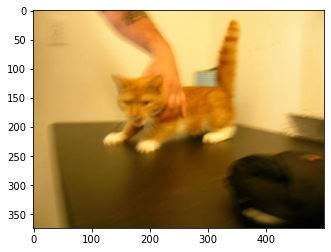

In [95]:
image = load_img(TRAIN_DIR+"/"+train_df['filename'][0])
plt.imshow(image)
print(train_df['category'][0]) ## Check if the df is created properly

## Create the model

In [102]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_32 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_33 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 30, 30, 64)       

In [103]:
# slipt trainning data and validate data
train_df, validation_df = train_test_split(train_df, test_size=0.20, random_state=50)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

# data Augmentaion - trainning data
image_gen_train = ImageDataGenerator( 
    rescale=1./255, 
    rotation_range=45, 
    width_shift_range=0.3, 
    height_shift_range=0.3,
    shear_range=0.1, 
    zoom_range=0.3, 
    horizontal_flip=True, 
    fill_mode='nearest'
)

train_dataset = image_gen_train.flow_from_dataframe(
    train_df,
    directory = TRAIN_DIR, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 16000 validated image filenames belonging to 2 classes.


In [104]:
# data Augmentaion - validation data
image_gen_val = ImageDataGenerator(rescale=1./255)

validation_dataset = image_gen_val.flow_from_dataframe(
    validation_df, 
    directory = TRAIN_DIR, 
    x_col = 'filename',
    y_col = 'category',
    target_size= (IMAGE_WIDTH,IMAGE_HEIGHT),
    class_mode = 'categorical',
    batch_size = BATCH_SIZE
)

Found 4000 validated image filenames belonging to 2 classes.


In [105]:
# data Augmentaion - test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_dataset = test_datagen.flow_from_dataframe(
    test_df, 
    directory=TEST_DIR, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size= (IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 12500 validated image filenames.


In [106]:
# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#call backs
checkpoint_filepath = 'best_weights.hdf5'

earlyStop = EarlyStopping(monitor='val_accuracy', patience=50, 
            verbose=1, mode='auto',restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, 
                                      save_weights_only=False, 
                                      monitor='val_accuracy',
                                      mode='auto', 
                                      save_best_only=True)
callbacks = [earlyStop, checkpoint]

print(earlyStop)

## Model Fitting

In [107]:
history = model.fit(train_dataset, 
                    validation_data = validation_dataset,
                    epochs = EPOCHS,
                    callbacks = callbacks)

Epoch 1/50
107/107 [==============================] - 123s 1s/step - loss: 0.9926 - accuracy: 0.5659 - val_loss: 4.9349 - val_accuracy: 0.5182
Epoch 2/50
107/107 [==============================] - 88s 819ms/step - loss: 0.7453 - accuracy: 0.5962 - val_loss: 1.1601 - val_accuracy: 0.4818
Epoch 3/50
107/107 [==============================] - 86s 806ms/step - loss: 0.6797 - accuracy: 0.6213 - val_loss: 0.7253 - val_accuracy: 0.5518
Epoch 4/50
107/107 [==============================] - 87s 815ms/step - loss: 0.6386 - accuracy: 0.6396 - val_loss: 0.7213 - val_accuracy: 0.5362
Epoch 5/50
107/107 [==============================] - 86s 808ms/step - loss: 0.6067 - accuracy: 0.6611 - val_loss: 0.7151 - val_accuracy: 0.5780
Epoch 6/50
107/107 [==============================] - 89s 835ms/step - loss: 0.5896 - accuracy: 0.6812 - val_loss: 0.5981 - val_accuracy: 0.6695
Epoch 7/50
107/107 [==============================] - 88s 818ms/step - loss: 0.5718 - accuracy: 0.6971 - val_loss: 0.6164 - val_accu

In [114]:
image = cv2.imread(TEST_DIR+'/'+test_df['filename'][0])
image = cv2.resize(image, (128, 128))
print(image)
# scale the pixels
image = image.astype('float') / 255.0

image = image.reshape((1,  image.shape[0], image.shape[1], image.shape[2]))
print(image)

[[[ 98  68  41]
  [101  65  39]
  [ 98  58  33]
  ...
  [205 105  75]
  [215 116  83]
  [173  84  48]]

 [[ 92  62  35]
  [ 99  62  36]
  [102  61  36]
  ...
  [205 103  80]
  [214 113  88]
  [175  81  52]]

 [[ 94  65  37]
  [ 97  60  34]
  [103  62  37]
  ...
  [199 101  76]
  [213 112  87]
  [185  86  58]]

 ...

 [[204 190 184]
  [211 196 190]
  [211 195 189]
  ...
  [154 158 172]
  [129 143 156]
  [117 139 152]]

 [[193 182 178]
  [198 186 182]
  [213 197 194]
  ...
  [119 131 134]
  [132 149 154]
  [115 137 144]]

 [[175 172 168]
  [198 186 184]
  [207 188 187]
  ...
  [198 187 197]
  [146 149 159]
  [ 65  88  96]]]
[[[[0.38431373 0.26666667 0.16078431]
   [0.39607843 0.25490196 0.15294118]
   [0.38431373 0.22745098 0.12941176]
   ...
   [0.80392157 0.41176471 0.29411765]
   [0.84313725 0.45490196 0.3254902 ]
   [0.67843137 0.32941176 0.18823529]]

  [[0.36078431 0.24313725 0.1372549 ]
   [0.38823529 0.24313725 0.14117647]
   [0.4        0.23921569 0.14117647]
   ...
   [0.803921

In [115]:
model.predict(image)

array([[0.3258496 , 0.67415035]], dtype=float32)

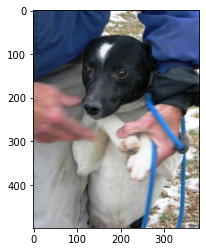

In [116]:
image = load_img(TEST_DIR+"/"+test_df['filename'][0])
plt.imshow(image)

In [124]:
model.save('Cat_Vs_Dogs',True)

INFO:tensorflow:Assets written to: Cat_Vs_Dogs\assets
